In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# I'm in love with my RTX 4060Ti❤️
torch.set_default_device("cuda")

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder("./train/", transform=tt.Compose([tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, generator=torch.Generator(device="cuda"))

In [4]:
latent_size = 128
# This will remain fixed to save samples
fixed_latent = torch.randn((1, latent_size, 1, 1))

In [5]:
generator = nn.Sequential(
    # in : latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 200 x 32 x 32

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
    # out: 3 x 256 x 256
    )

In [6]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    )

In [7]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    m = real_images.shape[0]
    real_preds = discriminator(real_images)
    real_targets = torch.ones((m, 1))
    real_loss = F.binary_cross_entropy(real_preds, real_targets)

    latent = torch.randn((m, latent_size, 1, 1))
    fake_images = generator(latent)
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros((m, 1))
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item()

In [8]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn((batch_size, latent_size, 1, 1))
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    fake_targets = torch.ones((batch_size, 1))
    loss = F.binary_cross_entropy(preds, fake_targets)
    loss.backward()
    opt_g.step()
    return loss.item()

In [9]:
def denorm_img(img):
    return img*stats[1][0] + stats[0][0]

In [10]:
def save_sample(idx):
    image = generator(fixed_latent)
    save_image(denorm_img(image), f"./generated/generated_img_{idx}.png")

In [11]:
def fit(epochs, lr, idx=0):
    torch.cuda.empty_cache()
    losses_d = []
    losses_g = []

    # Create_optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
    # Training Loop
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d = train_discriminator(real_images.cuda(), opt_d)
            loss_g = train_generator(opt_g)
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        print("Epochs [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}".format(epoch+1, epochs, loss_d, loss_g))
        save_sample(idx)
        idx += 1
    return losses_d, losses_g

In [12]:
# Loading trained state_dict
discriminator.load_state_dict(torch.load("./Discriminator_state_dict"))
generator.load_state_dict(torch.load("./Generator_state_dict"))

<All keys matched successfully>

In [ ]:
history = fit(300, 2e-4, 0)

In [79]:
torch.save(discriminator.state_dict(), "./Discriminator_state_dict")
torch.save(generator.state_dict(), "./Generator_state_dict")

In [13]:
# Generating Images
def generate_images(file_path):
    latent_tensor = torch.randn((64, latent_size, 1, 1))
    image = generator(latent_tensor)
    save_image(denorm_img(image), file_path)
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    fig.suptitle("Generating Waifus with Deep Convolutional Generative Adversarial Networks")
    for i, ax in enumerate(axes.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(denorm_img(image[i]).cpu().detach().permute(1, 2, 0))
    fig.savefig("./fig_waifu.png", dpi=200)

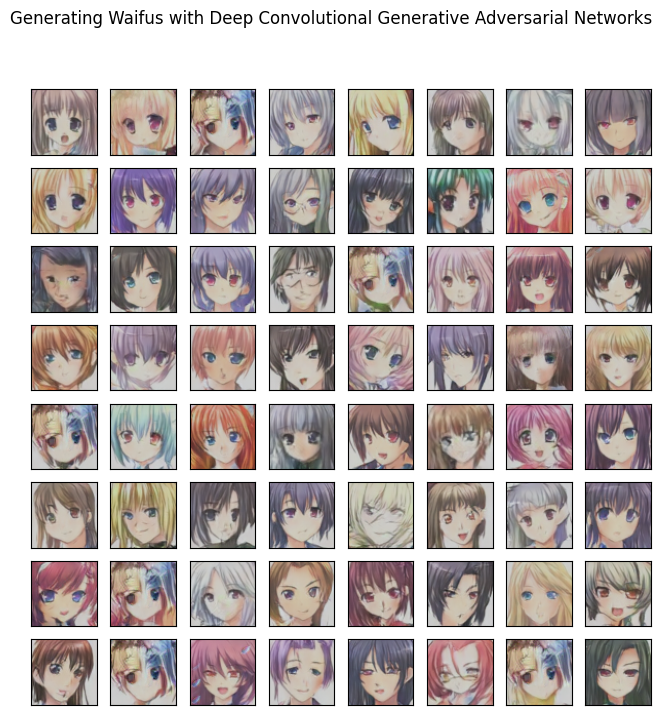

In [15]:
generate_images("./waifu.png")